# Data preprocessing (Merging the translated text)

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [3]:
def query_data(query):
    """
    Function to query data from the database using sqlalchemy
    :param query: 
    :return: pd.DataFrame
    
    Connection parameters:
    user = readmyzone
    password = (get from environment variable MYSQL_PASSWORD)
    host = 192.168.2.7
    port = 3306
    """
    
    # Create the connection string
    user = 'readmyzone'
    password = os.environ.get('MYSQL_PASSWORD')
    host = '192.168.2.7'
    port = '3306'
    db = 'myzone'
    connection_string = f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}'
    
    # Create the engine
    engine = create_engine(connection_string)
    
    try:
        # Query the data
        data = pd.read_sql(query, engine)
    except Exception as e:
        print(e)
        data = None
    
    return data

# Load the data

In [4]:
sav_incidencias = query_data('SELECT * FROM sav_incidencias')
sav_piezas = query_data('SELECT * FROM sav_piezas')
sav_estados = query_data('SELECT * FROM sav_estados')
sav_incidencias_tipo = query_data('SELECT * FROM sav_incidencias_tipo')

In [5]:
dataset = sav_incidencias.merge(sav_piezas, left_on='codigo', right_on='codigo_incidencia', how='left', suffixes=(None, '_pieza'))
dataset = dataset.merge(sav_estados, left_on='estado', right_on='id', how='left', suffixes=(None, '_estado'))
dataset = dataset.merge(sav_incidencias_tipo, left_on='tipo', right_on='id', how='left', suffixes=(None, '_tipo'))

In [6]:
clean_dataset = dataset[(dataset["tipo"] == 1) & (dataset["estado"].isin([2,6]))]

In [7]:
# Load from disk the text to translate dictionary
fields_to_translate = ["desc_problema", "problema", "descripcion"]
text_to_translate = {}
for text in fields_to_translate:
    text_to_translate[text] = pd.read_csv(f"../DATA/{text}.csv", sep='¬', encoding='utf-8-sig')

C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\1421433580.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_translate[text] = pd.read_csv(f"../DATA/{text}.csv", sep='¬', encoding='utf-8-sig')
C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\1421433580.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_translate[text] = pd.read_csv(f"../DATA/{text}.csv", sep='¬', encoding='utf-8-sig')
C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\1421433580.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; 

In [8]:
desc_problema_translated = pd.read_csv("../DATA/desc_problema_translated.csv", sep='¬', encoding='utf-8-sig', engine='python')
descripcion_translated = pd.read_csv("../DATA/descripcion_translated.csv", sep='¬', encoding='utf-8-sig', engine='python')
problema_translated = pd.read_csv("../DATA/problema_translated.csv", sep='¬', encoding='utf-8-sig', engine='python')# Data preprocessing (Merging the translated text)

In [9]:
# Delete rows with values (desc_problema, desc_problema_translated)
desc_problema_translated = desc_problema_translated[~desc_problema_translated["desc_problema_translated"].isin(["desc_problema_translated"])]
descripcion_translated = descripcion_translated[~descripcion_translated["descripcion_translated"].isin(["descripcion_translated"])]
problema_translated = problema_translated[~problema_translated["problema_translated"].isin(["problema_translated"])]

In [10]:
desc_problema_translated.count()

desc_problema               18099
desc_problema_translated    18099
dtype: int64

In [11]:
# Merge the translated text with the text_to_translate dataframe
desc_problema_translated = text_to_translate["desc_problema"].merge(desc_problema_translated, left_on="desc_problema", right_on="desc_problema", how="left")
descripcion_translated = text_to_translate["descripcion"].merge(descripcion_translated, left_on="descripcion", right_on="descripcion", how="left")
problema_translated = text_to_translate["problema"].merge(problema_translated, left_on="problema", right_on="problema", how="left")

In [12]:
# Fill NA with the original texts
desc_problema_translated.fillna({"desc_problema_translated": desc_problema_translated["desc_problema"]}, inplace=True)
descripcion_translated.fillna({"descripcion_translated": descripcion_translated["descripcion"]}, inplace=True)
problema_translated.fillna({"problema_translated": problema_translated["problema"]}, inplace=True)

In [13]:
desc_problema_translated.head(5)

,desc_problema,desc_problema_lg,desc_problema_translated
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,es,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,NO FUNCIONA,es,NO FUNCIONA
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,es,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,es,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",es,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR"


In [14]:
# Merge the translated text with the original dataset
clean_dataset = clean_dataset.merge(desc_problema_translated, left_on="desc_problema", right_on="desc_problema", how="left")
clean_dataset = clean_dataset.merge(descripcion_translated, left_on="descripcion", right_on="descripcion", how="left")
clean_dataset = clean_dataset.merge(problema_translated, left_on="problema", right_on="problema", how="left")

In [15]:
clean_dataset[["desc_problema"]].head(100)

,desc_problema
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,NO FUNCIONA
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR"
...,...
95,"por favor sacar este material a mi nombre, es ..."
96,"por favor sacar este material a mi nombre, es ..."
97,Pasarela Daikin: unos 3 minutos despues de arr...
98,Rejilla no funciona. Enviar una nueva retirar ...


In [16]:
clean_dataset.describe(include='all')

,id,web_id,codigo,creation_date,modification_date,company_id,user_id,ref_cliente,portes_airzone,devaluacion,...,titulo_en_tipo,titulo_fr_tipo,titulo_it_tipo,titulo_pt_tipo,desc_problema_lg,desc_problema_translated,descripcion_lg,descripcion_translated,problema_lg,problema_translated
count,44870.000000,44870.000000,44870,44870,44870,44870.000000,44870.000000,44848,44870.000000,44870.000000,...,44870,44870,44870,0,42131,42131,35105,33289,44834,43018
unique,NaN,NaN,34709,34666,28441,NaN,NaN,29831,NaN,NaN,...,1,1,1,0,33,28057,33,11384,33,29748
top,NaN,NaN,MPMAMZZN0E,2023-11-19 14:06:28,0000-00-00 00:00:00,NaN,NaN,RESO MATERIALE ASSISTENZE,NaN,NaN,...,guarantee,garantie,garanzia,NaN,es,NO FUNCIONA,en,TERMOSTATO,es,NO FUNCIONA
freq,NaN,NaN,38,38,7756,NaN,NaN,278,NaN,NaN,...,44870,44870,44870,NaN,15026,540,8597,735,14392,953
mean,31075.868041,1.636260,NaN,NaN,NaN,1341.928081,2708.666994,NaN,0.999265,0.000446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.000000,1.000000,NaN,NaN,NaN,0.000000,1.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,17417.250000,1.000000,NaN,NaN,NaN,240.000000,469.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,32110.000000,2.000000,NaN,NaN,NaN,492.000000,1953.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,45158.750000,2.000000,NaN,NaN,NaN,1935.000000,4230.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,58791.000000,5.000000,NaN,NaN,NaN,7632.000000,10284.000000,NaN,1.000000,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
for column in clean_dataset.columns:
    print(f"Column: {column}")

Column: id
Column: web_id
Column: codigo
Column: creation_date
Column: modification_date
Column: company_id
Column: user_id
Column: ref_cliente
Column: portes_airzone
Column: devaluacion
Column: pedido_sage
Column: abono_sage
Column: pedido_a3
Column: abono_a3
Column: tipo
Column: estado
Column: personaaz
Column: dire_envio_id
Column: dire_recogida_id
Column: peso3
Column: volumen3
Column: estadofr
Column: c_mail
Column: c_tel
Column: c_obs
Column: accepted_client
Column: desc_problema
Column: codigo_incidencia
Column: id_pieza
Column: user_id_pieza
Column: cod_articulo
Column: descripcion
Column: num_serie
Column: factura_albaran
Column: problema
Column: is_replacement
Column: creation_date_pieza
Column: modification_date_pieza
Column: id_estado
Column: ref
Column: color
Column: valor
Column: titulo_es
Column: titulo_en
Column: titulo_fr
Column: titulo_it
Column: titulo_pt
Column: id_tipo
Column: titulo_es_tipo
Column: titulo_en_tipo
Column: titulo_fr_tipo
Column: titulo_it_tipo
Colum

In [21]:
# Get only the columns with the fields of interest
text_to_analyse = clean_dataset[['desc_problema_translated','descripcion_translated','problema_translated']]
# Fill NA with empty string
text_to_analyse.fillna("", inplace=True)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\1741754689.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse.fillna("", inplace=True)


In [22]:
text_to_analyse.loc[:, 'text_to_analyse'] = text_to_analyse['desc_problema_translated'] + ' ' + text_to_analyse['descripcion_translated'] + ' ' + text_to_analyse['problema_translated']

C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\203136713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse.loc[:, 'text_to_analyse'] = text_to_analyse['desc_problema_translated'] + ' ' + text_to_analyse['descripcion_translated'] + ' ' + text_to_analyse['problema_translated']


In [23]:
text_to_analyse.head(10)

,desc_problema_translated,descripcion_translated,problema_translated,text_to_analyse
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,NO FUNCIONA,,NO FUNCIONA,NO FUNCIONA NO FUNCIONA
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",,Rafael el viernes llego mi pedido nº 23349 pa...,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa..."
5,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...
6,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...
7,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...","Error al pedir la pasarela, a última hora hubo..."
8,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...
9,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...


In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import string
# Download the stopwords and punkt
nltk.download('stopwords')
nltk.download('punkt')

def pre_process_text(text):
    """
    Function to preprocess the text
    Use nltk library to preprocess the text and return the preprocessed text
    Tokenize the text, remove stopwords, remove punctuation, lowercase the text
    :param text: text to preprocess
    :return: preprocessed text
    """
    try:
        text = str(text) # Convert all entries to string
    except Exception as e:
        print(f"Error occurred during text conversion: {e}")
        return ''
    # Create the stopwords list
    stop_words = set(stopwords.words('spanish'))
    # Create the stemmer
    stemmer = SnowballStemmer('spanish')
    # Tokenize the text
    tokens = word_tokenize(text)
    #print(f'After tokenizer: {tokens}')
    # Remove the stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words]
    #print(f'After remove stop words: {tokens}')
    # Remove the punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    #print(f'After remove punctuation: {tokens}')
    # Lowercase the text
    tokens = [word.lower() for word in tokens]
    #print(f'After lowercase words: {tokens}')
    # Stem the words
    tokens = [stemmer.stem(word) for word in tokens]
    # print(f'After Stemmer: {tokens}')
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\voliveira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\voliveira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
example_text = 'Hola, esto es un ejemplo de texto que vamos a preprocesar para testear'
pre_process_text(example_text)

'hol ejempl text vam preproces test'

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=False, preprocessor=pre_process_text, min_df=0.01, max_df=0.99)
vector = vectorizer.fit_transform(text_to_analyse['text_to_analyse'])
vector = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())

In [27]:
vector.sum().sort_values(ascending=False)

termostat    3688.203303
funcion      3090.564800
motor        1902.159468
bolet        1711.190105
airzon       1703.007755
                ...     
pon           185.762734
posibl        184.856724
codig         180.100850
deb           167.790854
ott           161.689362
Length: 181, dtype: float64

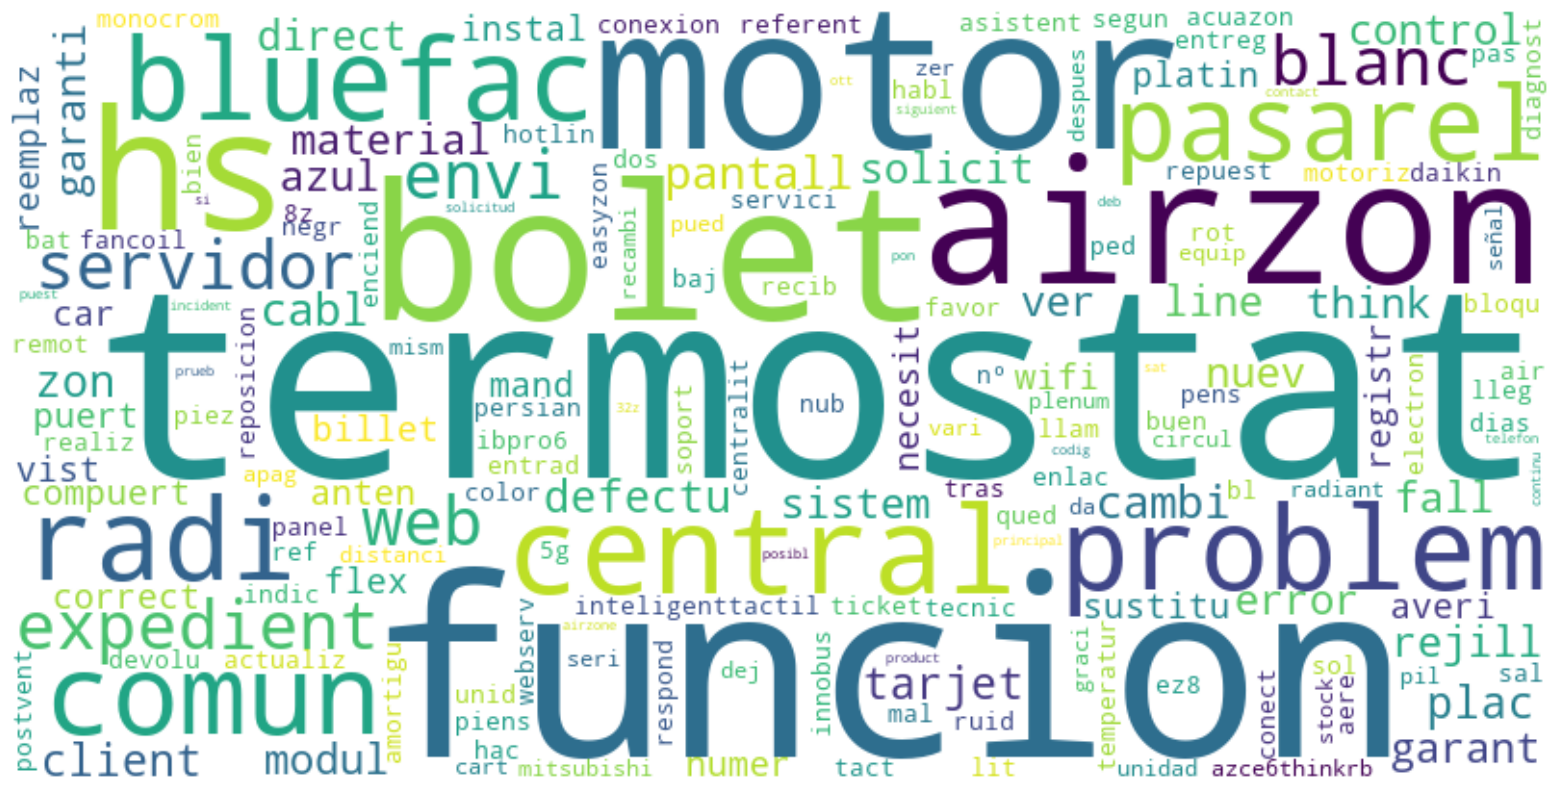

In [28]:
# Create a cloud of words with the most common words
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vector.sum().to_dict())
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

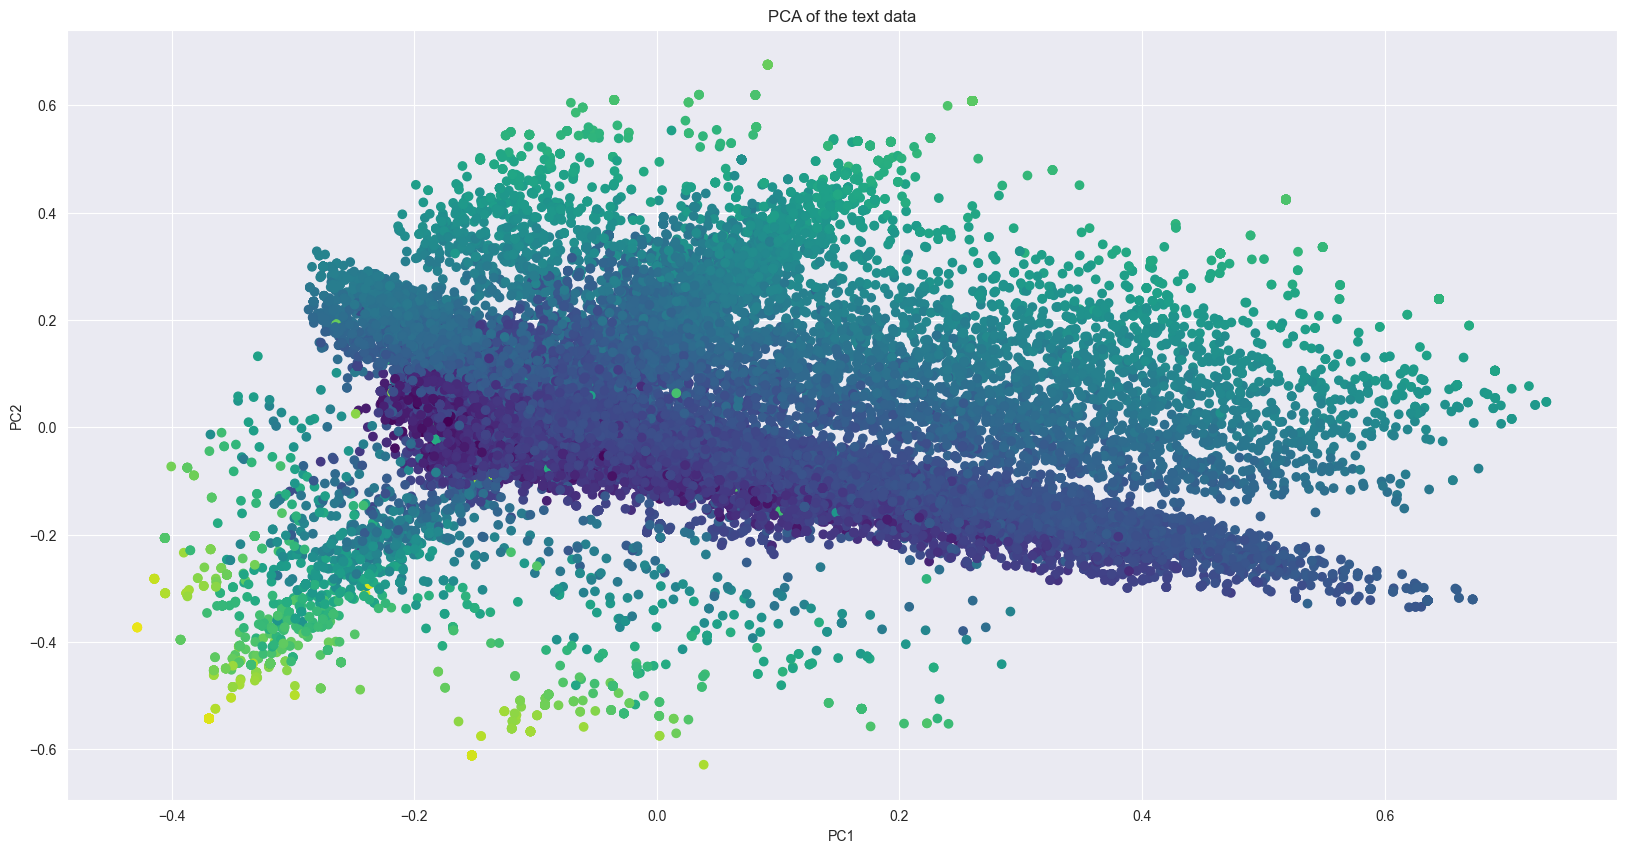

In [40]:
# Use PCA to reduce the dimensionality of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_vector = pca.fit_transform(vector)
pca_vector = pd.DataFrame(pca_vector, columns=['PC1', 'PC2', 'PC3'])

plt.figure(figsize=(20, 10))
plt.scatter(pca_vector['PC1'], pca_vector['PC2'], c=pca_vector['PC3'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of the text data')
plt.show()

In [30]:
# Plotting in 3D
%matplotlib qt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_vector['PC1'], pca_vector['PC2'], pca_vector['PC3'], c=pca_vector['PC3'], cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA of the text data')
plt.show()

In [31]:
%matplotlib inline

In [32]:
# Use another dimensionality reduction technique
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
tsne_vector = tsne.fit_transform(vector)
tsne_vector = pd.DataFrame(tsne_vector, columns=['TSNE1', 'TSNE2', 'TSNE3'])

In [41]:
%matplotlib qt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_vector['TSNE1'], tsne_vector['TSNE2'], tsne_vector['TSNE3'], c=tsne_vector['TSNE3'], cmap='viridis')
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('TSNE of the text data')
plt.show()

In [38]:
%matplotlib inline

In [42]:
# Create a sklearn pipeline to apply a clustering algorithm
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('kmeans', KMeans())
])

# Create grid search parameters
parameters = {
    'kmeans__n_clusters': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
}

grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=-1, verbose=1)
grid_search.fit(vector)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


GridSearchCV(cv=2, estimator=Pipeline(steps=[('kmeans', KMeans())]), n_jobs=-1,
             param_grid={'kmeans__n_clusters': [10, 15, 20, 25, 30, 35, 40, 45,
                                                50, 55, 60, 65, 70, 75, 80]},
             verbose=1)

In [43]:
# Check the best parameters
grid_search.best_params_

{'kmeans__n_clusters': 80}

In [44]:
# Add the cluster to the dataset
text_to_analyse['cluster'] = grid_search.best_estimator_.predict(vector)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\667776019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse['cluster'] = grid_search.best_estimator_.predict(vector)


In [45]:
# Plot the clusters
%matplotlib qt

# Plotting code
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_vector['PC1'], pca_vector['PC2'], pca_vector['PC3'], c=text_to_analyse['cluster'], cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA of the text data')
plt.show()

In [46]:
# Plot the clusters
%matplotlib qt

# Plotting code
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_vector['TSNE1'], tsne_vector['TSNE2'], tsne_vector['TSNE3'], c=text_to_analyse['cluster'], cmap='viridis')
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('PCA of the text data')
plt.show()

In [52]:
%matplotlib inline

In [48]:
text_to_analyse.head(10)

,desc_problema_translated,descripcion_translated,problema_translated,text_to_analyse,cluster
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,0
1,NO FUNCIONA,,NO FUNCIONA,NO FUNCIONA NO FUNCIONA,21
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,70
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,0
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",,Rafael el viernes llego mi pedido nº 23349 pa...,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",1
5,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,40
6,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,40
7,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...","Error al pedir la pasarela, a última hora hubo...",34
8,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,0
9,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,0


In [49]:
text_to_analyse[text_to_analyse['cluster']==1]['problema_translated']

4        Rafael  el viernes llego mi pedido nº 23349 pa...
18       Solicitan repuesto de los motores de una rejil...
20                                       REJILLA REPUESTO.
31                DIMENSIONES DIFERENTES A LAS DEL PEDIDO.
63                                      REJILLA SE BLOQUEA
                               ...                        
43578    Nº HOTLINE 240300756\r\nPasar a recoger y envi...
43601    NADA QUE DEVOLVER - AHORRAR AHORRAR CON AURORE...
43723                                                    *
43960    SOLICITAMOS REPOSICIÓN EN GARANTÍA DE REJILLA ...
44382    Motor de la rejilla averiado, enviar también l...
Name: problema_translated, Length: 957, dtype: object

In [50]:
# Create a temporary column 'temp_index' to assign a unique row identifier within each cluster
text_to_analyse['temp_index'] = text_to_analyse.groupby('cluster').cumcount()

# Pivot the DataFrame
pivoted_df = text_to_analyse.pivot(index='temp_index', columns='cluster', values='text_to_analyse')

# Optionally, if you don't want the multi-level index that comes from pivoting
pivoted_df.columns = [f'Cluster_{int(col)}' for col in pivoted_df.columns]

# Drop the index if it is irrelevant
pivoted_df.reset_index(drop=True, inplace=True)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\1497843397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse['temp_index'] = text_to_analyse.groupby('cluster').cumcount()


In [51]:
pivoted_df.head(50)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_70,Cluster_71,Cluster_72,Cluster_73,Cluster_74,Cluster_75,Cluster_76,Cluster_77,Cluster_78,Cluster_79
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",El termostato no funciona AZC3TACTOCSB visto c...,ABRIR ARCHIVO LÍNEA DIRECTA 3856\r\nPROBLEMA E...,PBP SA07M3B\r\nPROBLEMA DE TERMOSTATO AZCE6BLU...,BOLETO 22283 PLACA CENTRAL T.22283,pasarela HS Puerta de enlace de fan coil HS,Pérdida de com 28:CC:FF:00:07:7E hay que hacer...,Flexa con un historial de problemas. PLATINO I...,N°25941 TERMOSTATO IBPRO6 INTELIGENTE COULEUR ...,...,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,DEJA DE FUNCIONAR EL MOTOR DE UNA COMPUERTA MO...,PROBLEMES DES 5 CHNATIERS\r\nMASSAS X 1\r\nRCL...,SE HAN ROTO LAS TAPAS TRASERAS EN MAS DE UNA O...,INSTALACION CON PROBLEMAS DE CONEXION EN EL WE...,No funciona correctamente y le da error el sis...,VER LÍNEA DIRECTA 1 VER LÍNEA DIRECTA,"3Ud MINT Y 1 Ud MAIR, ruido al cerrar (crac, c...",Motor de amortiguador defectuoso REGISTRAR MOT...,BLUEFACE ACUA NO ENCIENDE SUPERFICIE AZA BLUEF...
1,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,INDICAN SE HA ESTROPEADO UN MOTOR DE UNA REJIL...,PARECE QUE A LA REJILLA LE FALTA LA PIEZA DE U...,Visualización de Pb en el mando a distancia BL...,BOLETO N°35376 Termostato IBPRO6 Blueface fila...,BOLETO 48923 PLATINO CENTRAL EASYZONE QAI BOLE...,pasarela HS Puerta de enlace de fan coil HS,Pérdida de com 28:CC:FF:00:07:7E hay que hacer...,Flexa con un historial de problemas. PLATINO I...,REPROGRAMACIÓN A REALIZAR\r\nARCHIVO 26664 TER...,...,EL TERMOSTATO RADIO E QUEDA BLOQUEADO. SE CONF...,MOTOR DE REJILLA AVERIADO RINT060015BKMTE SEGU...,PLATINO HS FLEXA PLATINA Envíe la tarjeta prim...,SE HAN ROTO LAS TAPAS TRASERAS EN MAS DE UNA O...,Actualizar 3 azwserverapp a 3 azwscloudwifi\nE...,1 MAIR Y 2 MINT NO HACEN CORRECTAMENTE EL RECO...,VER LÍNEA DIRECTA 5 VER LÍNEA DIRECTA,"3Ud MINT Y 1 Ud MAIR, ruido al cerrar (crac, c...",REGISTRO VARILLA DE MOTOR SPLIT CPPC 160 REGIS...,"SE RUEGA REPARACIÓN O MANDAR UNO NUEVO, YA QUE..."
2,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,"REJILLA LINEAL MOTORIZADA DE 1000X100, SE LA E...",VISTO CON SERVICIO PLATINO IBP6 AZC3 VISTO CON...,Tablero principal HS TERMOSTATO AZUL DOSIER LÍ...,BOLETO N°35408 Termostato IBPRO6 blueface blan...,REEMPLAZO DE PLACA SEGÚN BOLETO 50115 Platina ...,AZC03FIBPRO6 Tarjeta HS vista con Hotline PLAT...,Error de referencia Servidor web Nube Wifi par...,Flexa con un historial de problemas. 3 termost...,VER EXPEDIENTE N° 26910 TERMOSTATO IBPRO6 INTE...,...,EL TERMOSTATO RADIO E QUEDA BLOQUEADO. SE CONF...,MOTOR REJILLA INTELIGENTE EN GARANTIA MOTOR IN...,ACTUALIZACIÓN DEL SHOWROOM DE PARÍS DE AZC3 A ...,BLUEFACE ROTO. ERROR E1,Actualizar 3 azwserverapp a 3 azwscloudwifi\nE...,1 MAIR Y 2 MINT NO HACEN CORRECTAMENTE EL RECO...,Uno de los servomotores del comando configurad...,"3Ud MINT Y 1 Ud MAIR, ruido al cerrar (crac, c...",Motor de registro bloqueado. motor plenum Los ...,no enciende el primer led del modulo de suelo ...
3,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,"SOLICITAMOS DEVOLUCION DE LA REJILLA RECIBIDA,...",VISTO CON SERVICIO PASARELA LG PARA IBP6 AZC3 ...,LÍNEA DIRECTA DE ENTRADAS 7747 CARRITO POUR PA...,BOLETO N°36370 TERMOSTATO MONOCROMO AIRZONE BO...,BOLETO 52266 PLATINO CENTRAL EASYZONE QAI BOLE...,"PASARELA DE CONEXIÓN HS SS GARANTIZADA, ref AZ...",REEMPLAZO DE APP WEBSERVER con NUBE SERVIDOR W...,Flexa con un historial de problemas. 3 termost...,VER EXPEDIENTE N° 27352 TERMOSTATO IBPRO6 AIRZ...,...,EL TERMOSTATO SE QUEDA BLOQUEADO EL TERMOSTAT...,MOTOR AIRZONE AVERIADO EN COMPUERTA MOTORIZADA...,LA MÁQUINA YA NO VENTILA PLATINO .,SALIDA URGENTE\r\n\r\nLATIGUILLO DE PASARELA M...,mando de airzone que no funciona TERMOSTATO MA...,1 MAIR Y 2 MINT NO HACEN CORRECTAMENTE EL RECO...,ver con línea directa archivo airzone 2